# Traffic Analysis - Roetersstraat, Amsterdam
- Dataset was provided by our Partner Klaas 
- Dataset is dat collected by two camera sensor on Roeterstraat (https://telraam.net/nl/location/9000009380)
## Who's on the Street ? 

In [2]:
import pandas as pd

# Read the CSV file
df = pd.read_csv('raw_data.csv')
df['Date and Time (Local)'] = pd.to_datetime(df['Date and Time (Local)'])

# Calculate totals
total_pedestrians = df['Pedestrian Total'].sum()
total_bikes = df['Bike Total'].sum()
total_cars = df['Car Total'].sum()
total_all = total_pedestrians + total_bikes + total_cars

# Print percentages
print("Who's on the Street?\n")
print(f"Pedestrians: {total_pedestrians:,} ({total_pedestrians/total_all*100:.1f}%)")
print(f"Bikes: {total_bikes:,} ({total_bikes/total_all*100:.1f}%)")
print(f"Cars: {total_cars:,} ({total_cars/total_all*100:.1f}%)")

Who's on the Street?

Pedestrians: 266,525 (42.0%)
Bikes: 222,997 (35.1%)
Cars: 145,555 (22.9%)


## Who's Driving Above 30 km/h?



In [3]:
# Calculate vehicles under and over 30 km/h
speed_columns = [
    'Speed Car 0-10 km/h (%)', 'Speed Car 10-20 km/h (%)', 'Speed Car 20-30 km/h (%)',
    'Speed Car 30-40 km/h (%)', 'Speed Car 40-50 km/h (%)', 'Speed Car 50-60 km/h (%)',
    'Speed Car 60-70 km/h (%)', 'Speed Car 70+ km/h (%)'
]

# Calculate counts for each speed range
for col in speed_columns:
    speed_range = col.replace('Speed Car ', '').replace(' (%)', '')
    df[f'Count {speed_range}'] = (df[col] / 100) * df['Car Total']

# Calculate under and over 30 km/h
df['Under 30 km/h'] = df['Count 0-10 km/h'] + df['Count 10-20 km/h'] + df['Count 20-30 km/h']
df['Over 30 km/h'] = (df['Count 30-40 km/h'] + df['Count 40-50 km/h'] + 
                       df['Count 50-60 km/h'] + df['Count 60-70 km/h'] + df['Count 70+ km/h'])

# Remove NaN values
df_speed = df.dropna(subset=['Over 30 km/h'])

total_under = df_speed['Under 30 km/h'].sum()
total_over = df_speed['Over 30 km/h'].sum()
total_vehicles = total_under + total_over

# Print percentages
print("Speed Analysis: Over vs Under 30 km/h\n")
print(f"Vehicles under 30 km/h: {int(total_under):,} ({total_under/total_vehicles*100:.1f}%)")
print(f"Vehicles over 30 km/h: {int(total_over):,} ({total_over/total_vehicles*100:.1f}%)")

Speed Analysis: Over vs Under 30 km/h

Vehicles under 30 km/h: 67,969 (46.7%)
Vehicles over 30 km/h: 77,584 (53.3%)


## Traffic Patterns at Different Times of Day

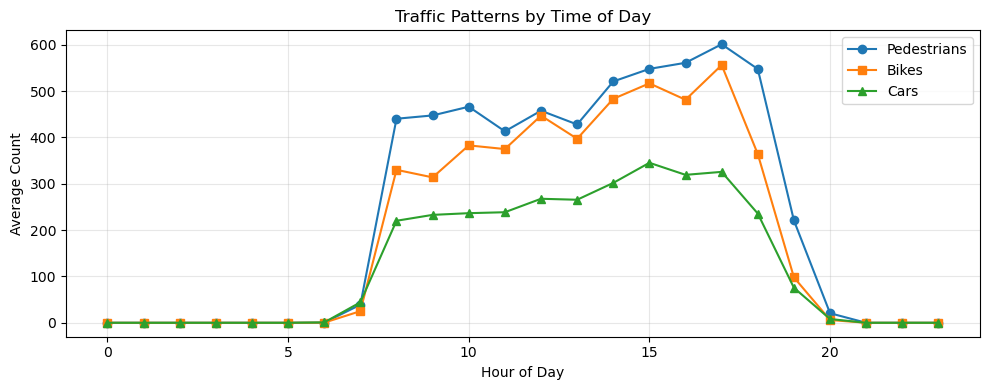

Peak hour for Pedestrians: 17:00
Peak hour for Bikes: 17:00
Peak hour for Cars: 15:00


In [4]:
import matplotlib.pyplot as plt

# Extract hour from datetime
df['Hour'] = df['Date and Time (Local)'].dt.hour

# Calculate average traffic by hour
hourly_avg = df.groupby('Hour')[['Pedestrian Total', 'Bike Total', 'Car Total']].mean()

# Create simple visualization
plt.figure(figsize=(10, 4))
plt.plot(hourly_avg.index, hourly_avg['Pedestrian Total'], label='Pedestrians', marker='o')
plt.plot(hourly_avg.index, hourly_avg['Bike Total'], label='Bikes', marker='s')
plt.plot(hourly_avg.index, hourly_avg['Car Total'], label='Cars', marker='^')
plt.xlabel('Hour of Day')
plt.ylabel('Average Count')
plt.title('Traffic Patterns by Time of Day')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Find and print peak hours
peak_pedestrians = hourly_avg['Pedestrian Total'].idxmax()
peak_bikes = hourly_avg['Bike Total'].idxmax()
peak_cars = hourly_avg['Car Total'].idxmax()

print(f"Peak hour for Pedestrians: {peak_pedestrians}:00")
print(f"Peak hour for Bikes: {peak_bikes}:00")
print(f"Peak hour for Cars: {peak_cars}:00")

### Sensor does not pick up who exactly uses the street during 9pm - 6am (just one "Nightime" category) !!
- Remove those values as they are irrelevant
- also remove values where --> uptime = poor 

In [15]:
df['Date and Time (Local)'] = pd.to_datetime(df['Date and Time (Local)'])

df_filtered = df[(df['Date and Time (Local)'].dt.hour > 6) & (df['Date and Time (Local)'].dt.hour < 21)]
df_filtered = df_filtered[df_filtered['Uptime'] != 'Poor uptime - 0.5']
df_filtered = df_filtered.drop(['Night Total', 'Hour'], axis=1)

# Save to new CSV file
df_filtered.to_csv('filtered_traffic_data.csv', index=False)

print(f"Original data: {len(df)} rows")
print(f"Filtered data: {len(df_filtered)} rows")
print(f"Removed: {len(df) - len(df_filtered)} rows")

Original data: 1121 rows
Filtered data: 651 rows
Removed: 470 rows


### Sidewalk size 
- public dataset by gemeente(https://maps.amsterdam.nl/open_geodata/)

In [ ]:
sidewalk_df = pd.read_csv('SIDEWALKS.csv', sep=';')

#Filter out "Nog onbepaald" (not determined)
sidewalk_df = sidewalk_df[sidewalk_df['ComfortLevel'] != 'Nog onbepaald']

sidewalk_df['ComfortLevel_numeric'] = (sidewalk_df['ComfortLevel']
    .str.replace('m', '', regex=False)
    .str.replace('Smaller dan ', '', regex=False)
    .str.replace('Saller dan ', '', regex=False)
    .str.replace(' of breder', '', regex=False)
    .astype(float))

#Average per street
street_avg = sidewalk_df.groupby('Streetname')['ComfortLevel_numeric'].mean()

#Overall average
overall_avg = sidewalk_df['ComfortLevel_numeric'].mean()
print(f"Overall Average Sidewalk width: {overall_avg:.2f}m")

#Roetersstraat average
roetersstraat_avg = sidewalk_df[sidewalk_df['Streetname'] == 'Roetersstraat']['ComfortLevel_numeric'].mean()
print(f"Roetersstraat Average Sidewalk width: {roetersstraat_avg:.2f}m")


Overall Average Sidewalk width: 1.90m
Roetersstraat Average Sidewalk width: 1.39m
